**[SOURCE]:** https://gerrychain.readthedocs.io/en/latest/user/recom/

## A Simple Recom Chain

In [27]:
import matplotlib.pyplot as plt
from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, constraints, accept)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from functools import partial
import pandas
from tqdm import tqdm

# Set the random seed so that the results are reproducible!
import random
random.seed(42)

In [28]:
graph = Graph.from_json("../data/gerrymandria.json")

my_updaters = {
    "population": updaters.Tally("TOTPOP"),
    "cut_edges": updaters.cut_edges
}

initial_partition = Partition(
    graph,
    assignment="district",
    updaters=my_updaters
)

In [29]:
# This should be 8 since each district has 1 person in it.
# Note that the key "population" corresponds to the population updater
# that we defined above and not with the population column in the json file.
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=2
)

In [30]:
recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=20
)

In [31]:
assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

In [32]:
%matplotlib inline
import matplotlib_inline.backend_inline
import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []

for i in range(len(assignment_list)):
    fig, ax = plt.subplots(figsize=(8,8))
    pos = {node :(data['x'],data['y']) for node, data in graph.nodes(data=True)}
    node_colors = [mcm.tab20(int(assignment_list[i][node]) % 20) for node in graph.nodes()]
    node_labels = {node: str(assignment_list[i][node]) for node in graph.nodes()}

    nx.draw_networkx_nodes(graph, pos, node_color=node_colors)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=node_labels)
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)

interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='500px'), max=19), Output()…

## Region-Aware ReCom

In [35]:
recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000
)

In [36]:
from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, constraints, accept)
from gerrychain.proposals import recom
from gerrychain.tree import bipartition_tree
from gerrychain.constraints import contiguous
from functools import partial
import random
random.seed(42)

graph = Graph.from_json("../data/gerrymandria.json")

my_updaters = {
    "population": updaters.Tally("TOTPOP"),
    "cut_edges": updaters.cut_edges
}

initial_partition = Partition(
    graph,
    assignment="district",
    updaters=my_updaters
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

method = partial(bipartition_tree, allow_pair_reselection=True)

proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=1,
    weight_dict={"muni": 1.0, "water_dist": 1.0},
    method=method
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=20
)

assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i + 1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

/opt/homebrew/lib/python3.11/site-packages/gerrychain/proposals/tree_proposals.py:107: ValueWarning: 
The sum of the weights in the weight dictionary is greater than 1.
Please consider normalizing the weights.
  warnings.warn(


## A Real-World Example

In [49]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas

In [51]:
graph = Graph.from_json("../data/PA_VTDs.json")

AttributeError: type object 'Graph' has no attribute 'from_shp'

In [39]:
elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]

In [40]:
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOT_POP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [41]:
initial_partition = GeographicPartition(
    graph,
    assignment="2011_PLA_1",
    updaters=my_updaters
)

In [42]:
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(
    recom,
    pop_col="TOT_POP",
    pop_target=ideal_population,
    epsilon=0.02,
    node_repeats=2
)

In [43]:
def cut_edges_length(p):
  return len(p["cut_edges"])

compactness_bound = constraints.UpperBound(
  cut_edges_length,
  2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [44]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [46]:
data = pandas.DataFrame(
    sorted(partition["SEN12"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/1000 [00:00<?, ?it/s]

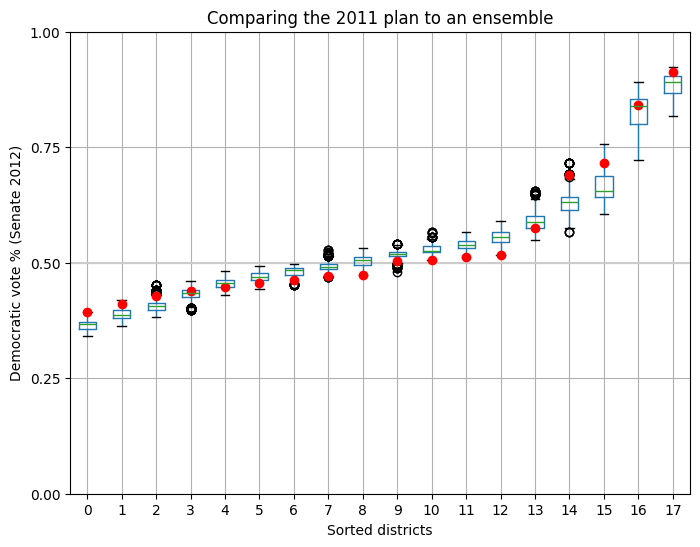

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2012)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

In [48]:
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []

for i, partition in enumerate(recom_chain):
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)

KeyError: 'perimeter'